In [4]:
import tqdm
import torch
import numpy as np
from matplotlib import pyplot as plt

from datamodules.datamodule import PneumoniaDataModule
from models import Classifier
from datamodules.transforms import train_transforms, test_val_transforms


# Global Params|

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Dataset

In [6]:
SIZE = 80
NORMALIZE = True

In [7]:
datamodule = PneumoniaDataModule(
    csv_path = "/home/konradkaranowski/SDU_Project/data_split_to_dirs.csv",
    batch_size = 1,
    train_transforms = train_transforms((SIZE, SIZE), NORMALIZE),
    val_transforms = test_val_transforms((SIZE, SIZE), NORMALIZE),
    test_transforms = test_val_transforms((SIZE, SIZE), NORMALIZE),    
)
datamodule.prepare_data()

/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:114: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:133: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


# Load Model

In [8]:
PATH = '/home/konradkaranowski/SDU_Project/save/PneumoniaSDU/14z6jlcp/checkpoints/epoch=30-step=2914.ckpt'

In [9]:
model = Classifier.load_from_checkpoint(PATH).model

/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_zero_warn(


# Use Model On Test Set

In [10]:
def test_model(model, test_dataloader):
    trues = []
    pred = []
    samples = []
    model.eval()
    model.to(DEVICE)
    for batch in tqdm.tqdm(test_dataloader):
        x, y = batch["x"], batch["y"]
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        if preds != y:
            samples.append({
                'sample': x.cpu(),
                'true': y.cpu(),
                'pred': preds.cpu(),
                'path': batch['path']
            })
        pred.append(preds.cpu().item())
        trues.append(y.cpu().item())
    return trues, pred, samples
        

In [11]:
trues, pred, samples = test_model(model, datamodule.test_dataloader())

/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
100%|██████████| 440/440 [00:04<00:00, 107.81it/s]


# Evaluate Model

In [12]:
from sklearn.metrics import accuracy_score, f1_score
from pretty_confusion_matrix import pp_matrix_from_data

## Confusion Matrix

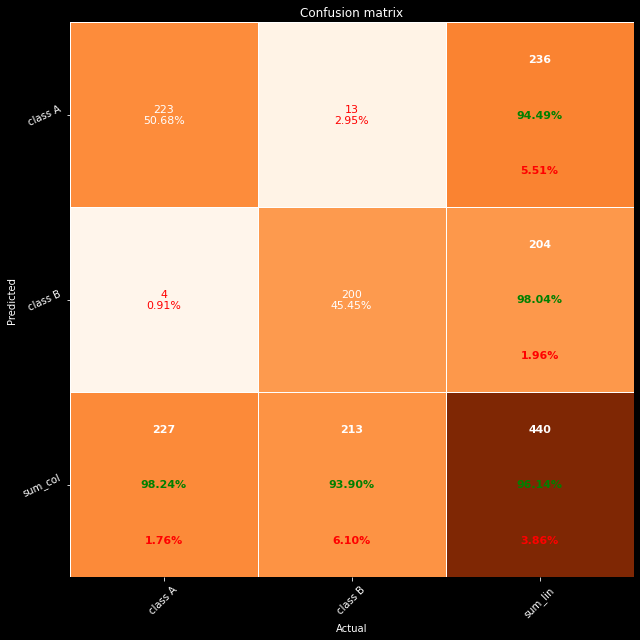

In [13]:
pp_matrix_from_data(trues, pred)

In [14]:
print(f'Accuracy: {round(accuracy_score(trues, pred), 4)} F1 macro: {round(f1_score(trues, pred, average="macro"), 4)}')

Accuracy: 0.9614 F1 macro: 0.9613


## Plot misclassified data

In [15]:
def plot_misclassified(samples):
    sz = min(2, len(samples) // 2)
    c = 2
    fig, ax = plt.subplots(c, sz, figsize=(12, 8))
    z = 0
    for i in range(c):
        for j in range(sz):
            sample = samples[z]
            ax[i, j].set_title(f'True: {sample["true"].item()} Pred: {sample["pred"].item()}')
            ax[i, j].imshow(sample['sample'].view(SIZE, SIZE))
            z += 1
    plt.show()


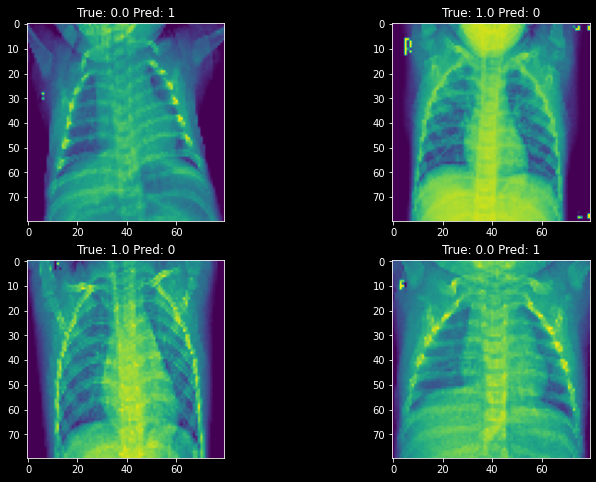

In [16]:
plot_misclassified(samples)

# Compare different models

In [63]:
MODELS = [
    '/home/konradkaranowski/SDU_Project/save/PneumoniaSDU/29eh70n0/checkpoints/epoch=22-step=2162.ckpt', 
    '/home/konradkaranowski/SDU_Project/save/PneumoniaSDU/3fdstfnd/checkpoints/epoch=27-step=2632.ckpt',
    '/home/konradkaranowski/SDU_Project/save/PneumoniaSDU/14z6jlcp/checkpoints/epoch=30-step=2914.ckpt',
    #'/home/konradkaranowski/SDU_Project/save/PneumoniaSDU/39d38xoa/checkpoints/epoch=16-step=1598.ckpt',
    #'/home/konradkaranowski/SDU_Project/save/PneumoniaSDU/369my1am/checkpoints/epoch=16-step=1598.ckpt',
    #'/home/konradkaranowski/SDU_Project/save/PneumoniaSDU/kh636vyt/checkpoints/epoch=17-step=1692.ckpt'
]


In [64]:
def test_ensemble(paths, test_dataloader):
    trues = []
    pred = []
    samples = []
    models = [
        Classifier.load_from_checkpoint(mpath).model for mpath in paths
    ]
    for model in models:
        model.eval()
        model.to(DEVICE)

    for batch in tqdm.tqdm(test_dataloader):
        x, y = batch["x"], batch["y"]
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        lgx = []
        for model in models:
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            lgx.append(preds.cpu().item())
        preds = np.bincount(lgx).argmax()
        if preds != y:
            samples.append({
                'sample': x.cpu(),
                'true': y.cpu(),
                'pred': preds,
                'path': batch['path']
            })
        pred.append(preds)
        trues.append(y.cpu().item())
    return trues, pred, samples


In [65]:
trues, preds, samples = test_ensemble(MODELS, datamodule.test_dataloader())
print(f'TEST Accuracy: {round(accuracy_score(trues, preds), 4)} F1 macro: {round(f1_score(trues, preds, average="macro"), 4)}')
trues, preds, samples = test_ensemble(MODELS, datamodule.val_dataloader())
print(f'VAL Accuracy: {round(accuracy_score(trues, preds), 4)} F1 macro: {round(f1_score(trues, preds, average="macro"), 4)}')

/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_zero_warn(
100%|██████████| 440/440 [00:08<00:00, 51.65it/s]
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/co

TEST Accuracy: 0.9841 F1 macro: 0.9841


100%|██████████| 264/264 [00:05<00:00, 51.65it/s]

VAL Accuracy: 0.9621 F1 macro: 0.9621


In [66]:
def test_ensemble_confidence(paths, test_dataloader):
    trues = []
    pred = []
    samples = []
    models = [
        Classifier.load_from_checkpoint(mpath).model for mpath in paths
    ]
    for model in models:
        model.eval()
        model.to(DEVICE)

    with torch.no_grad():
        for batch in tqdm.tqdm(test_dataloader):
            x, y = batch["x"], batch["y"]
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            lgx = []
            for model in models:
                logits = model(x)
                lgx.append(logits.cpu().detach().numpy())
            preds = np.argmax(np.sum(lgx, axis=0), axis=1)
            if preds != y:
                samples.append({
                    'sample': x.cpu(),
                    'true': y.cpu(),
                    'pred': preds,
                    'path': batch['path']
                })
            pred.append(preds)
            trues.append(y.cpu().item())
    return trues, pred, samples

In [67]:
trues, preds, samples = test_ensemble_confidence(MODELS, datamodule.test_dataloader())
print(f'TEST Accuracy: {round(accuracy_score(trues, preds), 4)} F1 macro: {round(f1_score(trues, preds, average="macro"), 4)}')
trues, preds, samples = test_ensemble_confidence(MODELS, datamodule.val_dataloader())
print(f'VAL ccuracy: {round(accuracy_score(trues, preds), 4)} F1 macro: {round(f1_score(trues, preds, average="macro"), 4)}')

/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_zero_warn(
100%|██████████| 440/440 [00:07<00:00, 57.68it/s]
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/co

TEST Accuracy: 0.9818 F1 macro: 0.9818


100%|██████████| 264/264 [00:04<00:00, 53.25it/s]

VAL ccuracy: 0.9621 F1 macro: 0.9621


/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/konradkaranowski/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_zero_warn(
100%|██████████| 264/264 [00:08<00:00, 32.75it/s]

Accuracy: 0.9583 F1 macro: 0.9583
